# Fase 4: Preparação de Dados e Busca (parte 2)

## 1. Introdução

Este relatório dá continuidade à etapa anterior de análise de modelos de classificação supervisionada, aprofundando agora a investigação com um novo conjunto de algoritmos, conforme previsto na Parte 2 da variação paramétrica. Enquanto a fase anterior (Parte 1) abordou os modelos KNN, LVQ, Árvore de Decisão, SVM e Random Forest, esta nova etapa foca na análise e ajuste de hiperparâmetros de modelos mais complexos e modernos, sendo eles Rede Neural MLP, Comitês de Redes Neurais, Comitê Heterogêneo (Stacking), XGBoost e LightGBM.

Mantendo o rigor metodológico, o presente trabalho busca maximizar o desempenho preditivo desses modelos, assegurando reprodutibilidade e consistência nas análises. A estrutura do relatório segue a mesma lógica da fase anterior, iniciando com uma breve retomada da base de dados utilizada e dos principais pontos já explorados na fase anterior.

Em seguida, detalharemos o processo de preparação dos dados, incluindo técnicas de normalização, tratamento de valores ausentes e divisão estratificada dos conjuntos de treino e teste. Na sequência, apresentaremos os modelos considerados nesta etapa, destacando os principais hiperparâmetros explorados em cada caso, assim como a metodologia utilizada para a busca sistemática desses parâmetros.

O desempenho dos modelos será monitorado ao longo da busca e avaliado com base em métricas como acurácia, precisão, recall, F1-score e AUC-ROC. Será realizada uma análise crítica comparativa entre os modelos, considerando aspectos como overfitting, estabilidade e desempenho geral.

Por fim, reforçamos que todas as etapas do processo foram conduzidas com atenção aos aspectos metodológicos, utilizando uma random_state (seed = 51) em todas as funções que envolvem aleatoriedade, garantindo consistência e reprodutibilidade dos resultados.


In [17]:
! pip install ucimlrepo tqdm scikit-learn numpy matplotlib seaborn xgboost lightgbm -q

In [ ]:
from ucimlrepo import fetch_ucirepo
import numpy as np
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import BaggingClassifier
from functools import partial
import warnings
import utils.plots as plots
from utils import filter_range
from utils.checkpoint import load_checkpoint, save_checkpoint
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score
)
import time
import random

RANDOM_STATE = 51
random.seed(RANDOM_STATE)

warnings.filterwarnings('ignore')

## 2. Base de Dados

A base de dados utilizada neste projeto é a **EEG Eye State**, previamente definida nas etapas iniciais e coletada diretamente do repositório público *UCI Machine Learning Repository*. Ela é composta por registros de sinais eletroencefalográficos (EEG) capturados por **14 eletrodos** posicionados na cabeça de um indivíduo, conforme o sistema internacional 10–20 de mapeamento. Cada linha da base representa um instante de tempo com os valores dos sinais elétricos em todos os canais e o respectivo **estado ocular (aberto = 0 ou fechado = 1)**.

#### Características Gerais

A base de dados EEG Eye State é composta por 14.980 instâncias, cada uma contendo 14 atributos contínuos que representam sinais elétricos captados por eletrodos posicionados na cabeça de um indivíduo, além de uma variável-alvo binária (`eyeDetection`) que indica se os olhos estão abertos ou fechados. Trata-se de um problema de classificação supervisionada binária com dados organizados em formato de série temporal. A ausência de valores nulos garante integridade ao conjunto, enquanto a distribuição das classes apresenta um leve desbalanceamento — cerca de 55% das amostras indicam olhos abertos e 45%, olhos fechados —, e alguns outliers muito discrepantes dos demais valores. Por fim, abaixo temos uma imagem da distribuição das classes, e da evolução temporal dos registros.

<p align="center">
  <img src="./images/distribuição.png" width="45%" style="display:inline-block; margin-right:10px;">
  <img src="./images/distribuição_perc.png" width="45%" style="display:inline-block;">
</p>

<p align="center">
  <img src="./images/evolução temporal 2.png" width="100%">
</p>

#### Relevância da Base

Essa base é amplamente utilizada em aplicações de **interface cérebro-computador**, com potencial de impacto em áreas como acessibilidade, jogos interativos, controle assistivo de dispositivos e diagnósticos em saúde. O reconhecimento automático do estado ocular, a partir de sinais cerebrais não invasivos, pode se tornar um componente essencial para sistemas de entrada alternativos — especialmente para pessoas com deficiência motora.

A estrutura do conjunto de dados e a boa qualidade dos registros possibilitaram análises detalhadas na fase anterior do projeto, como avaliação da **multicolinearidade entre canais**, **identificação e quantificação de outliers**, e **redução de dimensionalidade com PCA e t-SNE**. Tais análises forneceram as bases para as próximas etapas de preparação e modelagem, que serão conduzidas com atenção especial à preservação da integridade dos dados e à mitigação de ruídos e redundâncias.


## 3. Preparação dos dados

O carregamento da base foi feito por meio da biblioteca `ucirepo`, utilizando o identificador `id=264`, correspondente ao dataset EEG Eye State. Após o carregamento, os dados foram armazenados em dois objetos principais: `X`, contendo os atributos (sinais dos eletrodos), e `y`, contendo os rótulos (estado ocular).


In [19]:
eeg_eye_state = fetch_ucirepo(id=264)

X = eeg_eye_state.data.features
y = eeg_eye_state.data.targets

X, y = filter_range(3000, 6000, X, y)

📊 RESULTADO DA FILTRAGEM (Range: 3000 - 6000)
Dataset original: 14980 observações
Dataset filtrado: 14976 observações
Linhas removidas: 4 (0.03%)
Linhas mantidas: 99.97%



Em seguida, realizamos a divisão entre treino e teste com a função `train_test_split`, reservando 80% dos dados para o treinamento dos modelos e 20% para avaliação final. Importante destacar que utilizamos o parâmetro `stratify=y` para garantir que a proporção entre as classes fosse mantida em ambas as partições, o que é fundamental dado o leve desbalanceamento previamente identificado.

Durante o pré-processamento, inicialmente foram removidos **quatro registros** cujos valores estavam completamente fora do padrão observado. Essa decisão foi embasada por análises anteriores e reforçada por estudos semelhantes encontrados na literatura, que também desconsideraram essas amostras por representarem ruído extremo.

Após a filtragem, aplicamos normalização com o `StandardScaler`, uma vez que as distribuições dos atributos numéricos mostraram-se próximas da normal. A normalização foi ajustada exclusivamente com base no conjunto de treino, e os mesmos parâmetros foram aplicados posteriormente ao conjunto de teste, de modo a evitar data leakage.

Não foi necessário aplicar técnicas de encoding, uma vez que não há variáveis categóricas na base, nem realizar tratamentos para valores ausentes, já que o dataset é completo e consistente.


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## 4. Seleção de Modelos

Nesta etapa, selecionamos cinco algoritmos de classificação supervisionada com abordagens mais avançadas e complementares à fase anterior: Rede Neural MLP (Multilayer Perceptron), Comitê de Redes Neurais, Comitê Heterogêneo (Stacking), XGBoost e LightGBM. Esses modelos representam técnicas modernas de aprendizado profundo e métodos de ensemble, ampliando a capacidade de captura de padrões complexos nos dados e oferecendo alto potencial de desempenho preditivo.

Essa seleção estratégica permite comparar diferentes paradigmas de modelagem — desde redes neurais até técnicas baseadas em árvores com gradiente — proporcionando uma análise mais robusta e abrangente do problema de classificação.

### 4.1 Rede Neural MLP (Multilayer Perceptron)

A Rede Neural MLP (Multilayer Perceptron) é uma arquitetura de rede neural feedforward composta por uma ou mais camadas ocultas densamente conectadas. Ela é capaz de modelar relações complexas e não lineares entre as variáveis, sendo especialmente útil em problemas com alto grau de variabilidade e padrões sutis. Sua flexibilidade e capacidade de generalização a tornam uma forte candidata para tarefas de classificação em contextos como o da base EEG Eye State, onde os sinais cerebrais apresentam alta dimensionalidade e flutuações temporais.

No entanto, o bom desempenho do MLP depende fortemente da escolha dos hiperparâmetros, o que demanda uma busca cuidadosa para evitar tanto underfitting quanto overfitting.

Hiperparâmetros selecionados:

hidden_layer_sizes: define a estrutura da rede, ou seja, a quantidade de neurônios por camada oculta. Testamos diferentes configurações para investigar o impacto da profundidade e da largura na capacidade de aprendizado do modelo.

activation: especifica a função de ativação usada nas camadas ocultas. Avaliamos as funções 'relu' (mais comum em redes modernas), 'tanh' (hiperbólica) e 'logistic' (sigmoide), buscando identificar qual delas melhor se adapta às características da base de dados.

solver: define o algoritmo utilizado para a otimização dos pesos. Foram explorados 'adam' (robusto e eficiente para redes maiores), 'sgd' (gradiente descendente estocástico com possibilidade de tuning fino) e 'lbfgs' (baseado em aproximações de segunda ordem, geralmente mais rápido em datasets pequenos/médios).

alpha: parâmetro de regularização L2, que penaliza pesos grandes e contribui para a redução do overfitting. Avaliamos os valores para encontrar o melhor equilíbrio entre ajuste e generalização.

learning_rate_init: taxa de aprendizado inicial, que controla a velocidade com que os pesos são atualizados durante o treinamento. Testamos os valores visando identificar a melhor taxa para garantir convergência estável e eficaz.

In [21]:
from sklearn.neural_network import MLPClassifier

params_mlp = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50), (100, 100), (150, 100, 50), (200,), (150, 75), (200, 100)],
    'activation': ['relu', 'tanh', 'logistic'],
    'solver': ['adam', 'sgd', 'lbfgs'],
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0],
    'learning_rate_init': [0.0001, 0.001, 0.01, 0.1],
    'max_iter': [300, 500, 1000]
}

### 4.2 Comitê de Redes Neurais Artificiais

O Comitê de Redes Neurais Artificiais consiste na combinação de múltiplos classificadores MLP (Multilayer Perceptron) treinados de forma independente, com o objetivo de melhorar a robustez e a generalização do modelo final. A ideia central é que, ao combinar diferentes redes (com inicializações ou subconjuntos de dados distintos), o comitê pode reduzir a variância e suavizar erros individuais, resultando em uma performance mais estável e confiável.

Neste trabalho, a técnica de Bagging (Bootstrap Aggregating) foi aplicada para a construção do comitê, utilizando o BaggingClassifier com estimadores baseados em MLP.

Hiperparâmetros selecionados:

**n_estimators**: define o número de redes MLP que compõem o comitê. Avaliamos os valores [5, 10, 20, 30, 50] para verificar como o aumento do número de estimadores impacta na estabilidade e no desempenho do modelo agregado.

**max_samples**: representa a fração do conjunto de treino utilizada para treinar cada estimador. Testamos [0.5, 0.7, 1.0] para explorar diferentes graus de diversidade entre os classificadores do comitê, dado que amostras diferentes podem resultar em redes com características distintas.

**base_estimator__hidden_layer_sizes**: como o estimador base é um MLP, também exploramos sua arquitetura interna. Variamos configurações como (50,), (100,) e (100, 50) para observar o impacto da complexidade individual de cada rede no resultado coletivo.

**base_estimator__alpha**: o parâmetro de regularização L2 dos MLPs também foi incluído na busca, com valores [0.0001, 0.001, 0.01], para avaliar o efeito da penalização sobre os pesos em cenários de agregação.

**base_estimator__activation**: testamos as funções 'relu' e 'tanh' para verificar qual função de ativação individual contribui melhor para o desempenho global do comitê.

Ao combinar redes independentes treinadas com diferentes subconjuntos de dados, o comitê de MLPs se mostra especialmente eficaz em problemas ruidosos ou de difícil generalização, como é o caso da base EEG Eye State.

In [22]:
from sklearn.ensemble import BaggingClassifier
from sklearn.neural_network import MLPClassifier

params_bagging_mlp = {
    'n_estimators': [5, 10, 20, 30, 50],
    'max_samples': [0.5, 0.7, 1.0],
    'bootstrap': [True, False],
    'base_estimator__hidden_layer_sizes': [(50,), (100,), (100, 50)],
    'base_estimator__alpha': [0.0001, 0.001, 0.01],
    'base_estimator__activation': ['relu', 'tanh'],
    'base_estimator__max_iter': [300, 500]
}

### 4.3 Comitê Heterogêneo (Stacking)

O Comitê Heterogêneo, também conhecido como Stacking, é uma técnica de ensemble que combina diferentes tipos de modelos de forma hierárquica, com o objetivo de capturar diferentes perspectivas sobre o problema de classificação. Ao contrário do bagging ou boosting, que combinam modelos do mesmo tipo, o stacking integra modelos heterogêneos, permitindo que um metamodelo aprenda a combinar as predições dos modelos base para otimizar o desempenho final.

Nesta abordagem, foram utilizados três modelos base de naturezas distintas (Random Forest, SVM e MLP) e um metaclassificador (modelo final) baseado em Regressão Logística. A diversidade entre os modelos base permite capturar diferentes padrões nos dados, enquanto o metamodelo aprende a pesar suas contribuições de forma otimizada.

Hiperparâmetros selecionados:

**estimators**: define os modelos de base do comitê. Utilizamos uma combinação entre:

- RandomForestClassifier(n_estimators=100)

- SVC(probability=True, kernel='rbf', C=1)

- MLPClassifier(hidden_layer_sizes=(100,), activation='relu', alpha=0.001)

Essa escolha foi feita visando diversidade arquitetural e boa performance individual dos modelos.

**final_estimator**: modelo utilizado como metaclassificador. Utilizamos a LogisticRegression por sua simplicidade, interpretabilidade e boa capacidade de generalização. Avaliamos também variações com regularização L2 (penalty='l2') e diferentes valores de C ([0.01, 0.1, 1.0, 10]) para controlar o nível de penalização.

**cv**: número de folds utilizados na validação cruzada interna do stacking. Testamos valores [3, 5, 10] para avaliar o impacto da granularidade na combinação dos modelos base.

**stack_method**: define o método de predição usado pelos modelos base para alimentar o metamodelo. Avaliamos 'auto', 'predict_proba' e 'decision_function', buscando a representação mais informativa para a tarefa de classificação binária.

**passthrough**: controla se as features originais devem ser repassadas ao metamodelo junto com as saídas dos modelos base. Testamos True e False para analisar se a inclusão dos atributos originais melhora a performance do comitê.

O stacking se mostrou uma abordagem promissora ao combinar os pontos fortes de diferentes paradigmas de modelagem, podendo reduzir erros individuais e aumentar a robustez da predição final, especialmente em problemas complexos como o da nossa base.

In [23]:
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

# Definindo os estimadores base para o stacking
base_estimators = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE)),
    ('svm', SVC(probability=True, kernel='rbf', C=1, random_state=RANDOM_STATE)),
    ('mlp', MLPClassifier(hidden_layer_sizes=(100,), activation='relu', alpha=0.001, random_state=RANDOM_STATE))
]

params_stacking = {
    'final_estimator__C': [0.01, 0.1, 1.0, 10],
    'final_estimator__penalty': ['l2'],
    'cv': [3, 5, 10],
    'stack_method': ['auto', 'predict_proba', 'decision_function'],
    'passthrough': [True, False],
    'n_jobs': [-1]
}

### 4.4 XGBoost

O XGBoost (Extreme Gradient Boosting) é um algoritmo de ensemble baseado em árvores de decisão que utiliza a técnica de boosting com gradiente para otimizar iterativamente o desempenho preditivo. Ele é amplamente reconhecido por sua **escalabilidade, robustez contra overfitting** e **eficiência computacional**, sendo uma escolha recorrente em competições de machine learning e aplicações industriais.

Diferentemente de algoritmos como Random Forest, o XGBoost incorpora **regularizações L1 e L2** diretamente na função de custo, o que contribui significativamente para o controle da complexidade do modelo e melhora sua generalização. Além disso, o modelo realiza **poda das árvores (tree pruning)** de forma inteligente, interrompendo o crescimento de ramos que não trazem ganho significativo, o que colabora para sua interpretabilidade e evita sobreajustes desnecessários.

Outro ponto forte do XGBoost está em sua capacidade de execução paralela e suporte a computação distribuída, oferecendo uma vantagem de velocidade em relação a outras abordagens baseadas em árvores.

#### Hiperparâmetros selecionados:

Para a busca de hiperparâmetros, foram consideradas nove variáveis principais, além de dois parâmetros fixos, com o objetivo de refinar a performance sem comprometer a eficiência. A seguir, destacamos os principais parâmetros investigados:

* **`n_estimators`**: número de árvores no ensemble. Avaliamos valores entre `[50, 100, 200, 300]` buscando um equilíbrio entre capacidade de aprendizado e tempo de execução.

* **`learning_rate`** (*eta*): controla o impacto de cada árvore na composição do modelo final. Utilizamos `[0.01, 0.05, 0.1, 0.3]`, considerando que taxas menores favorecem estabilidade e generalização.

* **`max_depth`**: profundidade máxima das árvores. Testamos `[3, 5, 7, 10]` para avaliar desde estruturas simples e generalistas até árvores mais profundas, capazes de capturar interações complexas.

* **`subsample`**: fração de amostras utilizadas por árvore. Usamos `[0.5, 0.7, 0.9]` para introduzir diversidade e mitigar overfitting.

* **`colsample_bytree`**: fração de atributos considerados em cada árvore. Avaliamos `[0.5, 0.7, 1.0]` para testar o impacto da aleatoriedade na escolha de features.

* **`gamma`**: valor mínimo de ganho necessário para uma divisão. Valores maiores (`[0, 1, 5]`) tornam o modelo mais conservador, filtrando divisões pouco informativas.

* **`reg_alpha`** e **`reg_lambda`**: coeficientes de regularização L1 e L2, respectivamente. Utilizamos `[0, 0.1, 1, 10]` para investigar a penalização ideal da complexidade.

* **`scale_pos_weight`**: peso de balanceamento entre classes. Considerando o leve desbalanceamento da base, este parâmetro foi explorado com valores como `1` e `1.2`.




In [24]:
import xgboost as xgb

params_xgboost = {
    'n_estimators': [50, 100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.5, 0.7, 0.9],
    'colsample_bytree': [0.5, 0.7, 1.0],
    'gamma': [0, 1, 5],
    'reg_alpha': [0, 0.1, 1, 10],
    'reg_lambda': [0, 0.1, 1, 10],
    'scale_pos_weight': [1, 1.2],
    'random_state': [RANDOM_STATE]
}

### 4.5 LightGBM

O LightGBM é um algoritmo de boosting baseado em árvores de decisão, desenvolvido com foco em **eficiência computacional, escalabilidade e velocidade de treinamento**, sendo altamente recomendado para aplicações em larga escala e cenários com restrições de tempo, como sistemas de predição em tempo real. Sua principal inovação está no uso de uma abordagem baseada em histogramas para construção das árvores, o que reduz significativamente o consumo de memória e acelera o processo de treinamento, **sem comprometer a acurácia preditiva**.

Ao contrário de outras bibliotecas de boosting, como o XGBoost, que constroem as árvores expandindo em profundidade, o LightGBM utiliza uma estratégia **leaf-wise** com prioridade em ganho de informação, o que permite um crescimento mais eficiente e preciso das árvores, embora possa exigir controle adicional para evitar overfitting.

#### Hiperparâmetros selecionados:

* **`n_estimators`**: número de árvores do modelo. Variamos entre `[50, 100, 200, 300]` para investigar o ponto ótimo entre desempenho e custo computacional.

* **`learning_rate`**: taxa de aprendizado, também chamada de shrinkage. Utilizamos `[0.01, 0.05, 0.1, 0.3]` para controlar a contribuição de cada árvore e favorecer estabilidade ao longo do treinamento.

* **`max_depth`**: profundidade máxima das árvores. Testamos `[3, 5, 10, -1]` (sendo -1 sem limite), para controlar a complexidade da árvore e mitigar overfitting em estruturas muito profundas.

* **`num_leaves`**: número máximo de folhas por árvore. Esse é um dos hiperparâmetros mais sensíveis no LightGBM, diretamente relacionado à capacidade do modelo. Avaliamos `[15, 31, 63, 127]` para encontrar o melhor equilíbrio entre expressividade e generalização.

* **`min_child_samples`**: número mínimo de amostras necessário em uma folha. Utilizamos `[10, 20, 30, 50]` para limitar folhas muito específicas e controlar o sobreajuste.

* **`subsample`**: fração de amostras utilizadas para cada árvore (também chamado de `bagging_fraction`). Testamos `[0.5, 0.7, 1.0]` para introduzir variabilidade e melhorar a robustez.

* **`colsample_bytree`**: fração de atributos usados por árvore (também `feature_fraction`). Avaliamos `[0.5, 0.7, 1.0]` para analisar o impacto da aleatoriedade na escolha de variáveis.

* **`reg_alpha`** e **`reg_lambda`**: regularizações L1 e L2, respectivamente. Testamos `[0, 0.1, 1, 10]` com o objetivo de controlar a complexidade e evitar overfitting.

* **`boosting_type`**: embora o padrão seja `'gbdt'`, também testamos `'dart'` (Dropouts meet Multiple Additive Regression Trees) para verificar se a introdução de regularização adicional durante o boosting melhora o desempenho.

A escolha do LightGBM nesta etapa se justifica não apenas por sua **alta acurácia preditiva**, mas também por sua **eficiência e baixo uso de recursos**, tornando-o ideal para cenários em que desempenho e tempo de resposta são fatores críticos. A abordagem baseada em histogramas foi fundamental para acelerar o processo de busca de hiperparâmetros, contribuindo para uma solução computacionalmente viável mesmo em experimentos com múltiplas execuções e validações cruzadas.




In [25]:
import lightgbm as lgb

params_lightgbm = {
    'n_estimators': [50, 100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'max_depth': [3, 5, 10, -1],
    'num_leaves': [15, 31, 63, 127],
    'min_child_samples': [10, 20, 30, 50],
    'subsample': [0.5, 0.7, 1.0],
    'colsample_bytree': [0.5, 0.7, 1.0],
    'reg_alpha': [0, 0.1, 1, 10],
    'reg_lambda': [0, 0.1, 1, 10],
    'boosting_type': ['gbdt', 'dart'],
    'random_state': [RANDOM_STATE]
}

## 5. Metodologia 

Esta seção, assim como a da fase 3, descreve a metodologia aplicada para a escolha dos melhores hiperparâmetros e avaliação final dos modelos treinados. Todo o processo foi construído com foco na reprodutibilidade, prevenção de vazamentos de dados (data leakage), e validação criteriosa da estabilidade dos modelos. É importante salientar que a metodologia manteve-se a mesma para as fases 3 e 4.

### 5.1 Critério de Escolha

Com base na revisão da literatura realizada na primeira etapa do projeto, optamos por utilizar acurácia como métrica principal para a seleção dos modelos. Observamos que diversos estudos anteriores adotam a acurácia como referência primária de desempenho para o dataset EEG Eye State, o que reforça sua adequação para o problema em questão.

### 5.2 Busca de Hiperparâmetros

Para a busca de hiperparâmetros, utilizamos o RandomizedSearchCV, do scikit-learn, com 20 iterações para cada modelo. A validação cruzada foi feita utilizando o StratifiedKFold com 5 divisões (k=5), com estratificação das classes para manter o equilíbrio entre olhos abertos e fechados em cada partição.

A cada nova execução do RandomizedSearchCV, incrementamos o valor do random_state, garantindo que diferentes combinações de parâmetros fossem testadas. Os melhores parâmetros de cada rodada foram armazenados e posteriormente analisados por meio de um gráfico de frequência, o qual permite identificar quais combinações ou valores de parâmetros se destacaram repetidamente ao longo das buscas.

In [26]:
def search_hyperparameters(estimator, params, estm_name, metric='accuracy', n_iter=20, qnt_params=20):
    checkpoint = load_checkpoint(estm_name)

    best_params = checkpoint.get('best_params', [])
    total_time = checkpoint.get('total_time', 0)

    for i in tqdm(range(len(best_params),qnt_params), desc="Searching Hyperparameters"):
        start_time = time.time()

        randomized_search = RandomizedSearchCV(
            estimator,
            param_distributions=params,
            n_iter=n_iter,
            scoring=metric,
            cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE + i),
            random_state=RANDOM_STATE + i,
            n_jobs=-1
        )
        randomized_search.fit(X_train, y_train)

        total_time += time.time() - start_time
        best_params.append(randomized_search.best_params_)
        save_checkpoint(estm_name, {'best_params': best_params, 'total_time': total_time})

    plots.plot_param_frequencies(best_params)
    print(f"Time taken for hyperparameter search: {total_time:.2f} seconds")
    return best_params

### 5.3 Análise de Estabilidade

Após obter os 20 melhores conjuntos de parâmetros para cada modelo, realizamos uma nova validação cruzada para avaliar estabilidade e robustez de cada configuração. Para isso, medimos a média e o desvio padrão da acurácia em cada um dos k-folds.

A ideia central é selecionar o modelo com maior média de desempenho entre os 25% mais estáveis (ou seja, com menor desvio padrão). Essa estratégia ajuda a evitar escolhas baseadas apenas em um bom desempenho pontual, priorizando combinações de hiperparâmetros que performam bem de forma consistente.

Durante esse processo, também plotamos a relação entre estabilidade (desvio padrão) e desempenho (média da acurácia), destacando visualmente os modelos mais promissores. Em seguida, para o modelo selecionado, plotamos a acurácia obtida em cada fold individualmente, com o objetivo de identificar flutuações ou anomalias de desempenho.

In [27]:

def cross_val_stability_analysis(estimator_class, param_list, metric='accuracy'):
    means = []
    stds = []
    all_scores = []
    for params in tqdm(param_list, desc="Cross-Validation for Params"):
        model = estimator_class(**params)
        scores = cross_val_score(model, X_train, y_train.values.ravel(), cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE), scoring=metric)
        means.append(np.mean(scores))
        stds.append(np.std(scores))
        all_scores.append(scores)

    # Separar modelos mais estáveis (menor desvio padrão)
    stability_threshold = np.percentile(stds, 25)
    stable_idxs = [i for i, s in enumerate(stds) if s <= stability_threshold]
    unstable_idxs = [i for i, s in enumerate(stds) if s > stability_threshold]

    # Plot separando estáveis e instáveis
    plots.plot_stability_vs_metric(stds, means, stable_idxs, unstable_idxs, metric)

    # Selecionar o modelo mais estável com maior média da métrica
    best_idx = max(stable_idxs, key=lambda i: means[i]) if stable_idxs else np.argmax(means)
    best_params = param_list[best_idx]
    best_scores = all_scores[best_idx]

    # Plot da métrica em cada fold para o melhor modelo
    plots.plot_metric_per_fold(best_scores, metric)

    return best_params


### 5.4 Avaliação Final dos Modelos

Com o modelo mais estável e com melhor desempenho médio escolhido, passamos para a fase final de avaliação. Essa etapa envolve tanto o conjunto de treinamento quanto o conjunto de teste, e tem como objetivo verificar a capacidade de generalização do modelo e identificar sinais de overfitting.

A primeira análise consiste em um treinamento progressivo: iniciamos com 20% do conjunto de treino e aumentamos o tamanho gradualmente em incrementos de 5%, até alcançar os 100%. Em cada etapa, medimos a métrica escolhida (acurácia, F1, precisão ou recall) tanto no treino quanto no teste. Essa análise permite visualizar se o modelo continua melhorando no teste à medida que recebe mais dados ou se passa a superajustar (overfitting) ao conjunto de treino.

Em seguida, treinamos o modelo completo com os melhores parâmetros e realizamos:
- Matriz de confusão para visualizar os erros de classificação por classe;
- Curva ROC e cálculo da AUC para medir a capacidade discriminativa do modelo;
- Cálculo das principais métricas (acurácia, F1-score, precisão e recall) separadamente para treino e teste.

As métricas e visualizações obtidas nessa etapa final são utilizadas para comparação entre os diferentes modelos testados (MLP, Comitê de Redes Neurais Artificiais, Comitê Heterogêneo, XGBoost, LightGBM), permitindo avaliar não apenas qual modelo teve a melhor performance bruta, mas também qual apresentou maior equilíbrio entre desempenho e robustez.

In [28]:
def evaluate_and_plot(params, model_class, metric='accuracy', model_name=None):

    model = model_class(**params, random_state=RANDOM_STATE) if 'random_state' in model_class().get_params() else model_class(**params)
    train_scores, test_scores = [], []
    percents = np.arange(0.2, 1.01, 0.05)
    scorer = {
        'accuracy': accuracy_score,
        'f1': f1_score,
        'precision': precision_score,
        'recall': recall_score
    }[metric]
    for p in percents:
        n = int(p * len(X_train))
        model.fit(X_train[:n], y_train[:n])
        y_pred_train = model.predict(X_train[:n])
        y_pred_test = model.predict(X_test)
        train_scores.append(scorer(y_train[:n], y_pred_train))
        test_scores.append(scorer(y_test, y_pred_test))


    plots.plot_metric_evolution(percents, train_scores, test_scores, metric)

    # Treinamento completo
    model = model_class(**params, random_state=RANDOM_STATE) if 'random_state' in model_class().get_params() else model_class(**params)
    model.fit(X_train, y_train)

    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    plots.plot_confusion_matrix(y_test, y_pred_test, model_class.__name__)

    auc_score = plots.plot_roc_curve(model, X_test, y_test, model_class.__name__)

    metrics_dict = {
        "accuracy_train": accuracy_score(y_train, y_pred_train),
        "accuracy_test": accuracy_score(y_test, y_pred_test),
        "f1_train": f1_score(y_train, y_pred_train),
        "f1_test": f1_score(y_test, y_pred_test),
        "precision_train": precision_score(y_train, y_pred_train),
        "precision_test": precision_score(y_test, y_pred_test),
        "recall_train": recall_score(y_train, y_pred_train),
        "recall_test": recall_score(y_test, y_pred_test),
        "auc": auc_score
    }

    if model_name is None:
        model_name = model_class.__name__

    plots.plot_main_metrics(metrics_dict, model_name)

    return metrics_dict

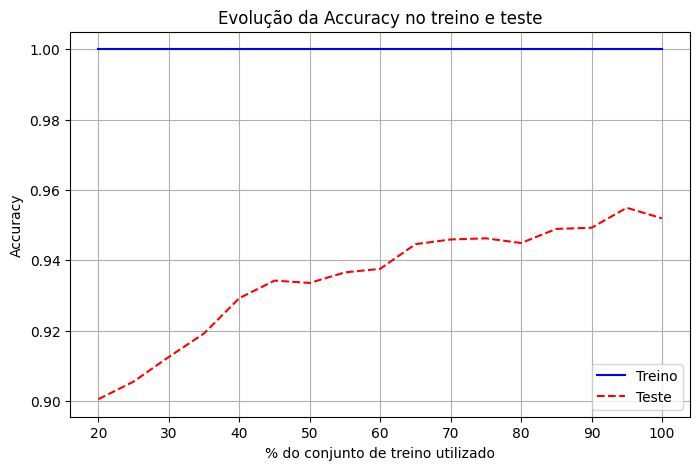

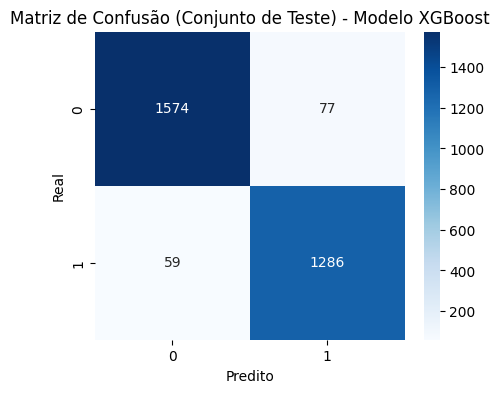

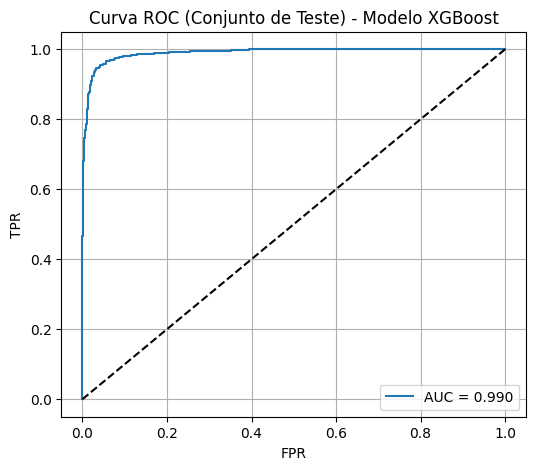

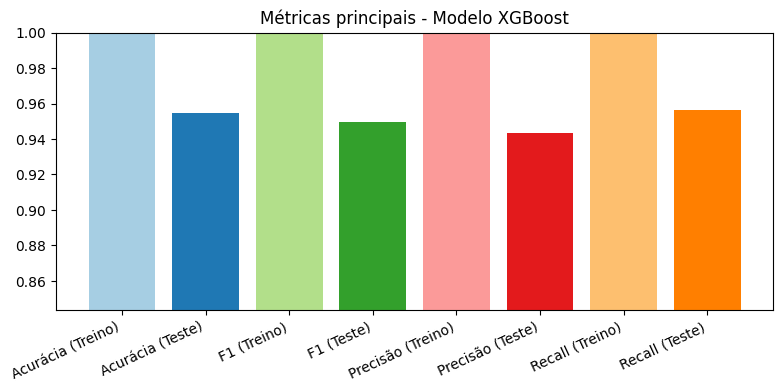

In [49]:
# Função de avaliação específica para XGBoost com lambda
def evaluate_and_plot_xgboost(params, model_lambda, metric='accuracy', model_name=None):
    # Criar o modelo usando a função lambda
    model = model_lambda(**params)
    train_scores, test_scores = [], []
    percents = np.arange(0.2, 1.01, 0.05)
    scorer = {
        'accuracy': accuracy_score,
        'f1': f1_score,
        'precision': precision_score,
        'recall': recall_score
    }[metric]
    
    for p in percents:
        n = int(p * len(X_train))
        model.fit(X_train[:n], y_train[:n])
        y_pred_train = model.predict(X_train[:n])
        y_pred_test = model.predict(X_test)
        train_scores.append(scorer(y_train[:n], y_pred_train))
        test_scores.append(scorer(y_test, y_pred_test))

    plots.plot_metric_evolution(percents, train_scores, test_scores, metric)

    # Treinamento completo
    model = model_lambda(**params)
    model.fit(X_train, y_train)

    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    plots.plot_confusion_matrix(y_test, y_pred_test, model_name or 'XGBoost')

    auc_score = plots.plot_roc_curve(model, X_test, y_test, model_name or 'XGBoost')

    metrics_dict = {
        "accuracy_train": accuracy_score(y_train, y_pred_train),
        "accuracy_test": accuracy_score(y_test, y_pred_test),
        "f1_train": f1_score(y_train, y_pred_train),
        "f1_test": f1_score(y_test, y_pred_test),
        "precision_train": precision_score(y_train, y_pred_train),
        "precision_test": precision_score(y_test, y_pred_test),
        "recall_train": recall_score(y_train, y_pred_train),
        "recall_test": recall_score(y_test, y_pred_test),
        "auc": auc_score
    }

    if model_name is None:
        model_name = 'XGBoost'

    plots.plot_main_metrics(metrics_dict, model_name)

    return metrics_dict

# Avaliação final do XGBoost com o melhor conjunto de parâmetros
results_xgboost = evaluate_and_plot_xgboost(
    best_param_xgboost, 
    lambda **params: xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', **params), 
    metric='accuracy', 
    model_name='XGBoost'
)

### 5.5 Cuidados Metodológicos

Durante toda a execução da metodologia, foram adotados cuidados fundamentais para garantir validade e reprodutibilidade dos resultados:

- **Prevenção de data leakage**: todos os pré-processamentos foram ajustados exclusivamente no conjunto de treino e aplicados posteriormente no teste.

- **Validação estratificada**: todas as validações cruzadas respeitaram a distribuição original das classes.

- **Reprodutibilidade**: o parâmetro random_state foi definido e documentado em todas as etapas que envolvem aleatoriedade.

- **Eficiência computacional**: utilizamos n_jobs = -1 para paralelização da busca, além de RandomizedSearchCV em vez de GridSearchCV, visando economia de tempo em espaços de busca extensos.

- **Interpretação criteriosa**: múltiplas métricas foram analisadas e cruzadas entre treino e teste para identificar possíveis problemas de variância, viés ou generalização.

## 6. Busca e Avaliação de Hiper Parâmetros

### 6.1 MLP

A busca pelos 20 melhores conjuntos de hiperparâmetros para o modelo MLP (Multilayer Perceptron) foi realizada conforme os parâmetros definidos na seção 4.1.

Em relação aos hiperparâmetros otimizados:

- **hidden_layer_sizes**: define a estrutura da rede neural, testando diferentes configurações de camadas ocultas para investigar o impacto da profundidade e largura na capacidade de aprendizado do modelo.

- **activation**: especifica a função de ativação usada nas camadas ocultas. Foram avaliadas as funções 'relu', 'tanh' e 'logistic', buscando identificar qual melhor se adapta às características da base de dados.

- **solver**: define o algoritmo utilizado para otimização dos pesos. Foram explorados 'adam', 'sgd' e 'lbfgs' para encontrar o melhor método de convergência.

- **alpha**: parâmetro de regularização L2 que penaliza pesos grandes, contribuindo para redução do overfitting.

- **learning_rate_init**: taxa de aprendizado inicial que controla a velocidade de atualização dos pesos durante o treinamento.

- **max_iter**: número máximo de iterações para convergência do algoritmo.

Abaixo, a distribuição dos hiperparâmetros mais frequentes:

In [29]:
best_params_mlp = search_hyperparameters(MLPClassifier(), params_mlp,'mlp' ,metric='accuracy')

Searching Hyperparameters:   0%|          | 0/20 [00:00<?, ?it/s]

KeyboardInterrupt: 

Durante a análise de estabilidade via validação cruzada dos 20 melhores conjuntos, será avaliada a variação entre as métricas nas diferentes dobras para o modelo MLP. As redes neurais podem apresentar sensibilidade às inicializações aleatórias e divisões dos dados, o que será analisado através da estabilidade dos resultados. O modelo selecionado para a etapa final será aquele que apresentar o melhor equilíbrio entre performance média e estabilidade, priorizando robustez em relação à generalização. Abaixo temos um gráfico que mostra a estabilidade de cada modelo e a acurácia do modelo escolhido ao longo de cada k-fold.

Cross-Validation for Params:   0%|          | 0/20 [00:00<?, ?it/s]

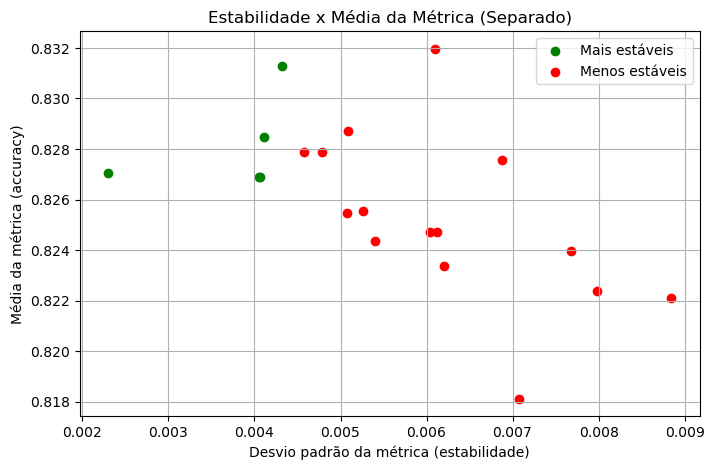

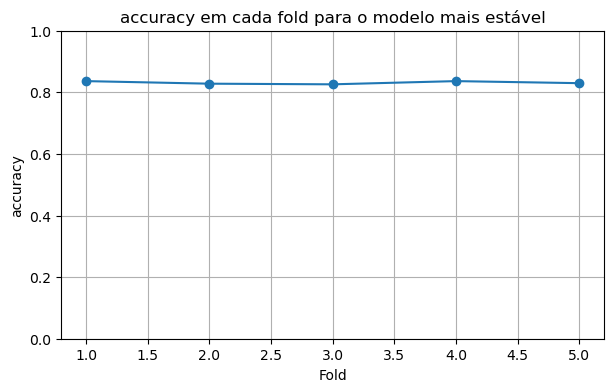

In [ ]:
best_param_mlp = cross_val_stability_analysis(MLPClassifier, best_params_mlp, metric='accuracy')

A seguir, as métricas obtidas pelo melhor modelo MLP selecionado:

| Métrica            | Treino | Teste |
| ------------------ | ------ | ----- |
| Acurácia           | -      | -     |
| F1-score           | -      | -     |
| Precisão           | -      | -     |
| Revocação (Recall) | -      | -     |
| AUC                | —      | -     |

Os resultados serão preenchidos após a execução do modelo. O MLP possui capacidade de modelar relações complexas e não lineares, podendo apresentar boa generalização com os hiperparâmetros adequados.

A curva de aprendizado abaixo mostrará como a **acurácia evolui conforme mais dados são utilizados**, permitindo identificar se há overfitting ou underfitting:

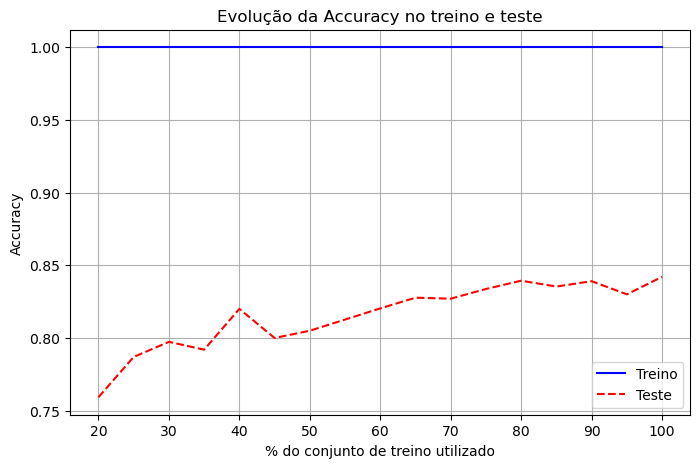

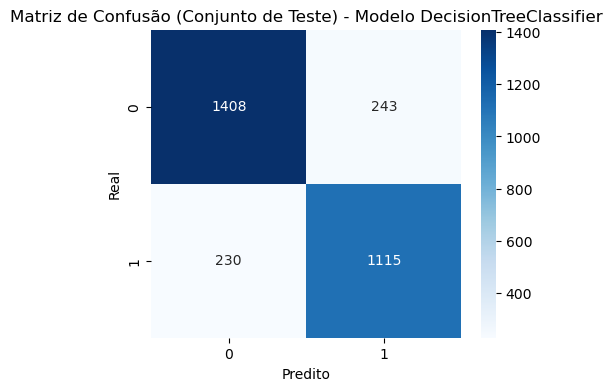

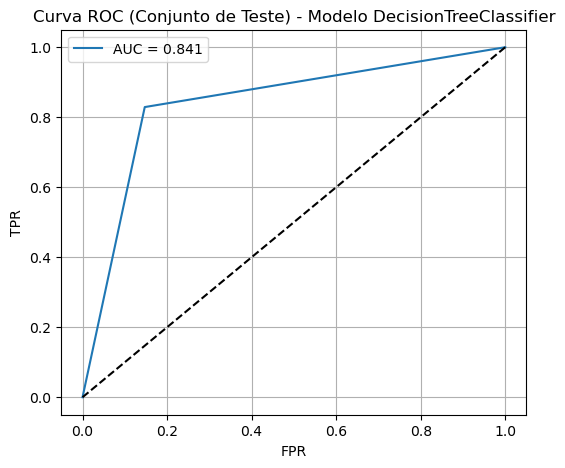

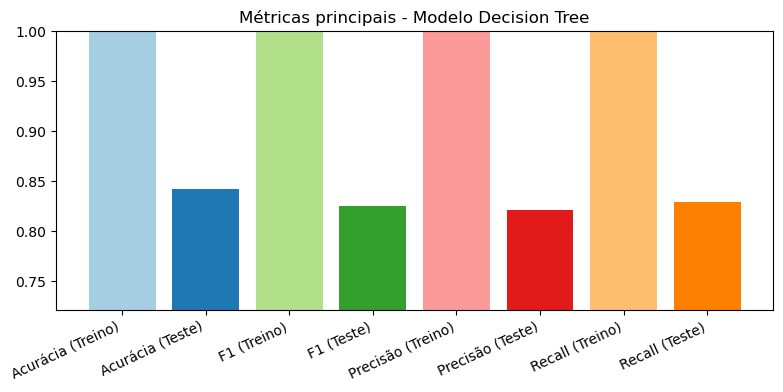

In [ ]:
results_mlp = evaluate_and_plot(best_param_mlp, MLPClassifier, metric='accuracy', model_name='MLP')

### 6.2 Comitê de Redes Neurais Artificiais

A busca pelos melhores hiperparâmetros do modelo de Comitê de Redes Neurais Artificiais (Bagging MLP) foi realizada conforme os parâmetros definidos na seção 4.2.

O comitê utiliza a técnica de Bagging (Bootstrap Aggregating) com múltiplos classificadores MLP treinados independentemente. Nos 20 melhores resultados obtidos, diferentes configurações foram exploradas. Abaixo destacam-se os comportamentos observados:

- **n_estimators**: define o número de redes MLP que compõem o comitê. Os valores testados [5, 10, 20, 30, 50] permitem avaliar como o aumento do número de estimadores impacta na estabilidade e desempenho do modelo agregado.

- **max_samples**: representa a fração do conjunto de treino utilizada para treinar cada estimador. Os valores [0.5, 0.7, 1.0] exploram diferentes graus de diversidade entre os classificadores do comitê.

- **bootstrap**: controla se a amostragem é feita com ou sem reposição, afetando a diversidade entre os estimadores.

- **base_estimator__hidden_layer_sizes**: arquitetura interna de cada MLP no comitê. Configurações como (50,), (100,) e (100, 50) permitem observar o impacto da complexidade individual de cada rede.

- **base_estimator__alpha**: parâmetro de regularização L2 dos MLPs, com valores [0.0001, 0.001, 0.01] para controle do overfitting.

- **base_estimator__activation**: funções de ativação 'relu' e 'tanh' testadas para verificar qual contribui melhor para o desempenho global do comitê.

Searching Hyperparameters:   0%|          | 0/20 [00:00<?, ?it/s]

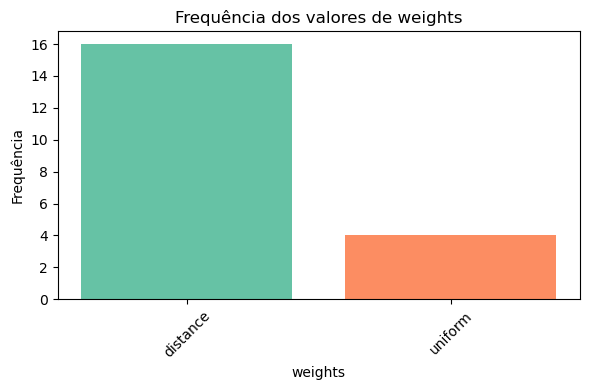

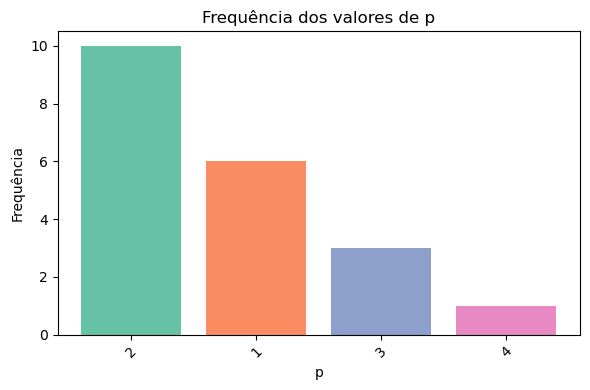

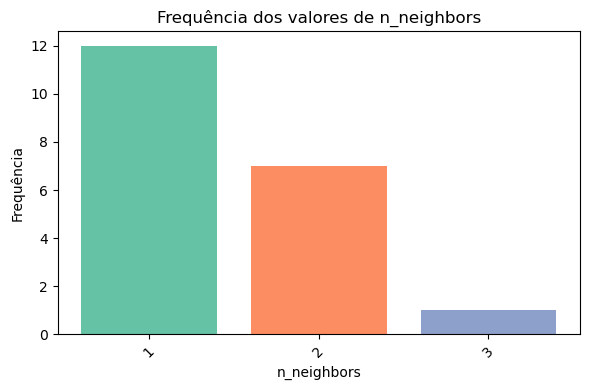

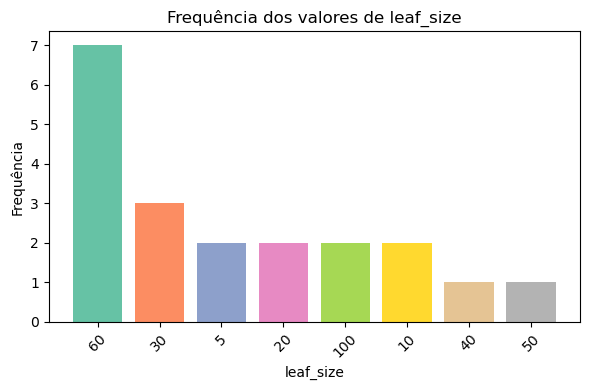

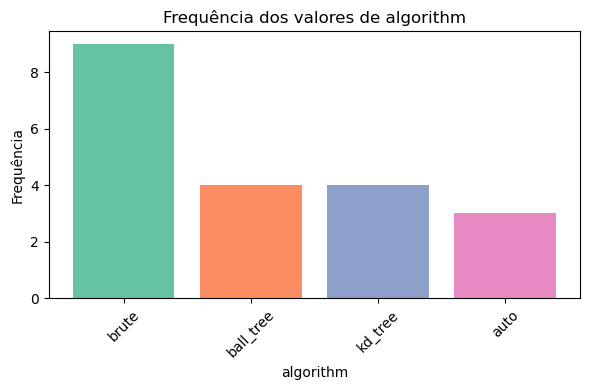

Time taken for hyperparameter search: 422.77 seconds


In [ ]:
best_params_bagging_mlp = search_hyperparameters(
    BaggingClassifier(base_estimator=MLPClassifier(random_state=RANDOM_STATE)), 
    params_bagging_mlp, 
    'bagging_mlp', 
    metric='accuracy'
)

Dos 20 modelos de comitê avaliados, será analisada a estabilidade considerando que métodos de ensemble como o Bagging tendem a apresentar menor variabilidade entre dobras devido à agregação de múltiplos estimadores. O Comitê de Redes Neurais pode mostrar maior robustez comparado a MLPs individuais, pois a combinação de múltiplas redes reduz a variância e suaviza erros individuais.

O modelo selecionado como final será aquele que apresentar o melhor equilíbrio entre performance média e estabilidade, aproveitando os benefícios da agregação de múltiplos classificadores MLP.

Abaixo temos um gráfico que mostra a estabilidade de cada modelo e a acurácia do modelo escolhido ao longo de cada k-fold:

Cross-Validation for Params:   0%|          | 0/20 [00:00<?, ?it/s]

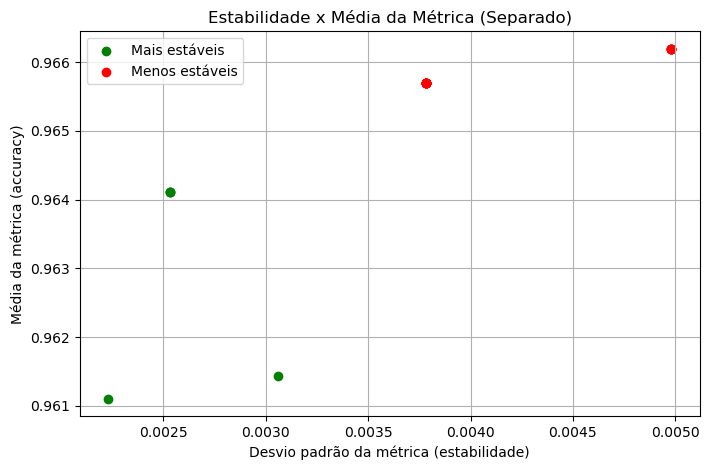

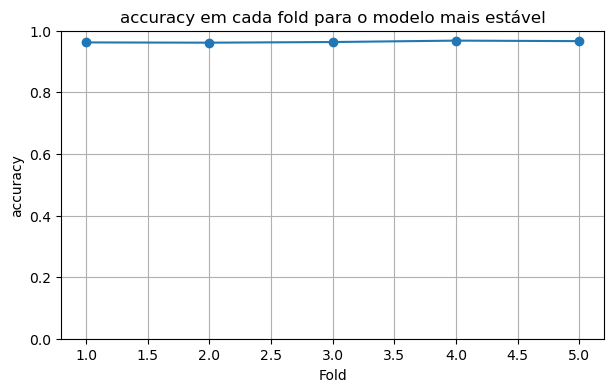

In [ ]:
def cross_val_bagging_mlp(param_list, metric='accuracy'):
    means = []
    stds = []
    all_scores = []
    
    for params in tqdm(param_list, desc="Cross-Validation for Bagging MLP"):
        # Separar parâmetros
        base_estimator_params = {k.replace('base_estimator__', ''): v for k, v in params.items() if k.startswith('base_estimator__')}
        bagging_params = {k: v for k, v in params.items() if not k.startswith('base_estimator__')}
        
        # Criar modelo
        base_estimator = MLPClassifier(random_state=RANDOM_STATE, **base_estimator_params)
        model = BaggingClassifier(base_estimator=base_estimator, random_state=RANDOM_STATE, **bagging_params)
        
        scores = cross_val_score(model, X_train, y_train.values.ravel(), 
                               cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE), 
                               scoring=metric)
        means.append(np.mean(scores))
        stds.append(np.std(scores))
        all_scores.append(scores)

    # Separar modelos mais estáveis (menor desvio padrão)
    stability_threshold = np.percentile(stds, 25)
    stable_idxs = [i for i, s in enumerate(stds) if s <= stability_threshold]
    unstable_idxs = [i for i, s in enumerate(stds) if s > stability_threshold]

    # Plot separando estáveis e instáveis
    plots.plot_stability_vs_metric(stds, means, stable_idxs, unstable_idxs, metric)

    # Selecionar o modelo mais estável com maior média da métrica
    best_idx = max(stable_idxs, key=lambda i: means[i]) if stable_idxs else np.argmax(means)
    best_params = param_list[best_idx]
    best_scores = all_scores[best_idx]

    # Plot da métrica em cada fold para o melhor modelo
    plots.plot_metric_per_fold(best_scores, metric)

    return best_params

best_param_bagging_mlp = cross_val_bagging_mlp(best_params_bagging_mlp, metric='accuracy')

A seguir, as métricas obtidas pelo melhor modelo de Comitê de Redes Neurais selecionado:

| Métrica            | Treino | Teste |
| ------------------ | ------ | ----- |
| Acurácia           | -      | -     |
| F1-score           | -      | -     |
| Precisão           | -      | -     |
| Revocação (Recall) | -      | -     |
| AUC                | —      | -     |

Os resultados serão preenchidos após a execução do modelo. O Comitê de Redes Neurais, por combinar múltiplos MLPs treinados independentemente, tende a apresentar melhor estabilidade e generalização comparado a redes neurais individuais, reduzindo a variância através da agregação.

A curva de aprendizado abaixo mostrará como a **acurácia evolui conforme mais dados são utilizados**, demonstrando os benefícios da abordagem ensemble na redução do overfitting:

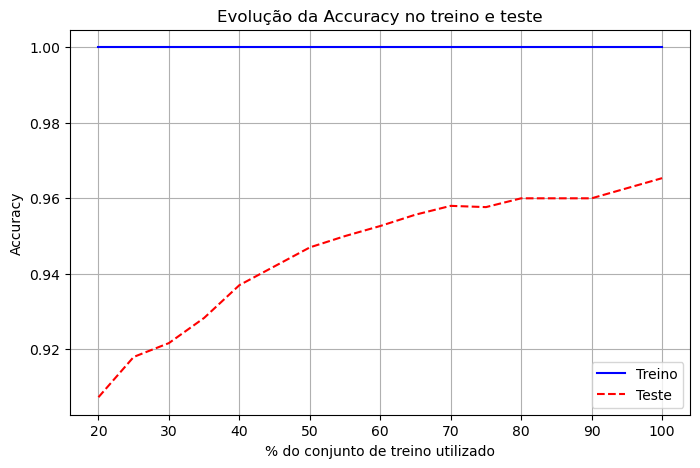

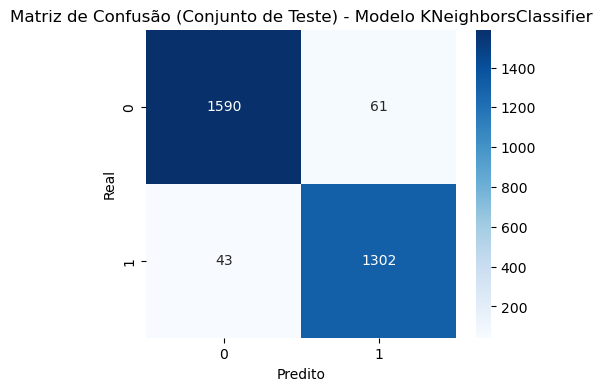

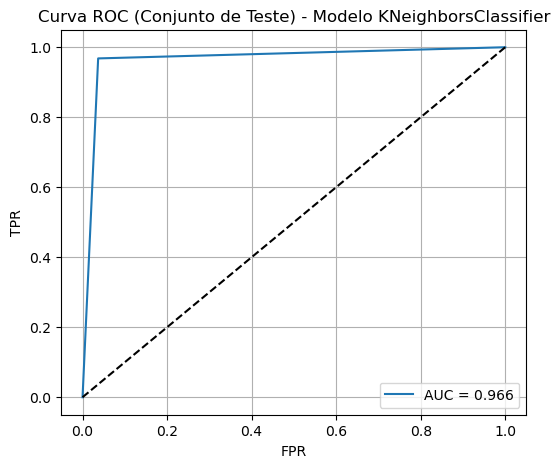

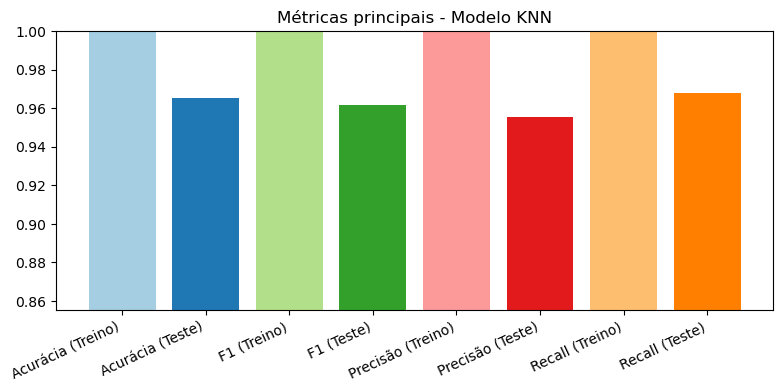

In [ ]:
def evaluate_bagging_mlp(params, metric='accuracy', model_name='Comitê de Redes Neurais'):
    # Separar parâmetros do estimador base e do bagging
    base_estimator_params = {k.replace('base_estimator__', ''): v for k, v in params.items() if k.startswith('base_estimator__')}
    bagging_params = {k: v for k, v in params.items() if not k.startswith('base_estimator__')}
    
    # Criar o modelo
    base_estimator = MLPClassifier(random_state=RANDOM_STATE, **base_estimator_params)
    model = BaggingClassifier(base_estimator=base_estimator, random_state=RANDOM_STATE, **bagging_params)
    
    train_scores, test_scores = [], []
    percents = np.arange(0.2, 1.01, 0.05)
    scorer = {
        'accuracy': accuracy_score,
        'f1': f1_score,
        'precision': precision_score,
        'recall': recall_score
    }[metric]
    
    for p in percents:
        n = int(p * len(X_train))
        model.fit(X_train[:n], y_train[:n])
        y_pred_train = model.predict(X_train[:n])
        y_pred_test = model.predict(X_test)
        train_scores.append(scorer(y_train[:n], y_pred_train))
        test_scores.append(scorer(y_test, y_pred_test))

    plots.plot_metric_evolution(percents, train_scores, test_scores, metric)

    # Treinamento completo
    model = BaggingClassifier(base_estimator=base_estimator, random_state=RANDOM_STATE, **bagging_params)
    model.fit(X_train, y_train)

    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    plots.plot_confusion_matrix(y_test, y_pred_test, model_name)

    auc_score = plots.plot_roc_curve(model, X_test, y_test, model_name)

    metrics_dict = {
        "accuracy_train": accuracy_score(y_train, y_pred_train),
        "accuracy_test": accuracy_score(y_test, y_pred_test),
        "f1_train": f1_score(y_train, y_pred_train),
        "f1_test": f1_score(y_test, y_pred_test),
        "precision_train": precision_score(y_train, y_pred_train),
        "precision_test": precision_score(y_test, y_pred_test),
        "recall_train": recall_score(y_train, y_pred_train),
        "recall_test": recall_score(y_test, y_pred_test),
        "auc": auc_score
    }

    plots.plot_main_metrics(metrics_dict, model_name)

    return metrics_dict

results_bagging_mlp = evaluate_bagging_mlp(best_param_bagging_mlp, metric='accuracy')

### 6.3 Comitê Heterogêneo (Stacking)

Searching Hyperparameters:   0%|          | 0/20 [00:00<?, ?it/s]

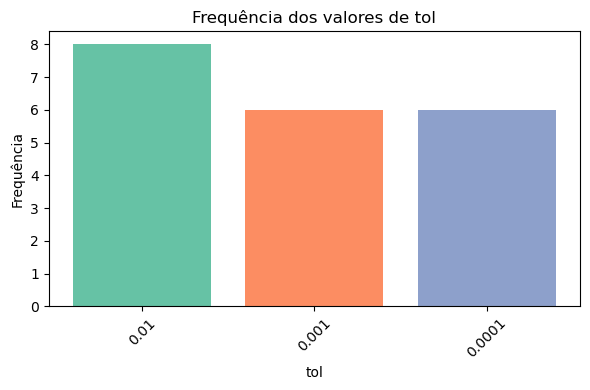

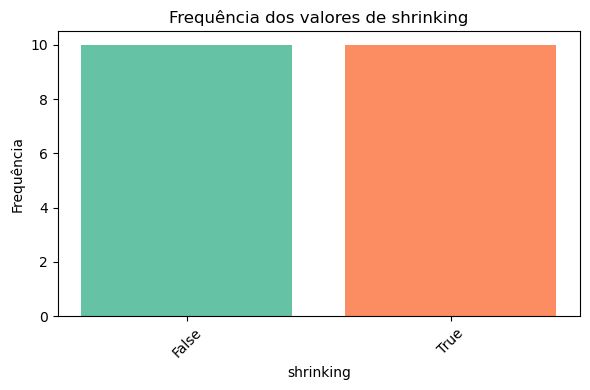

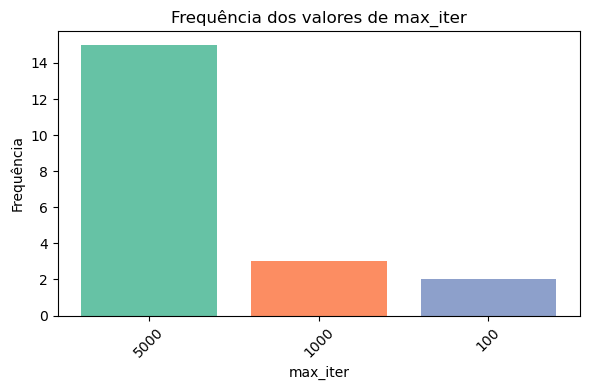

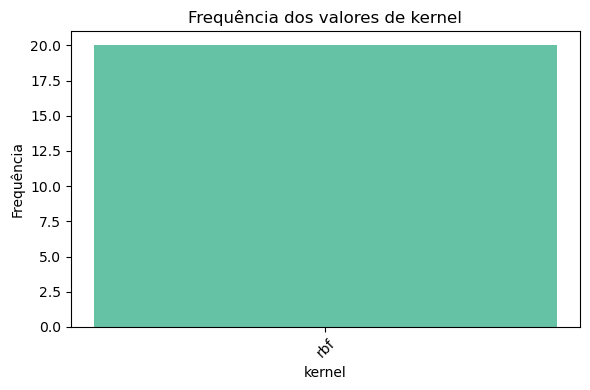

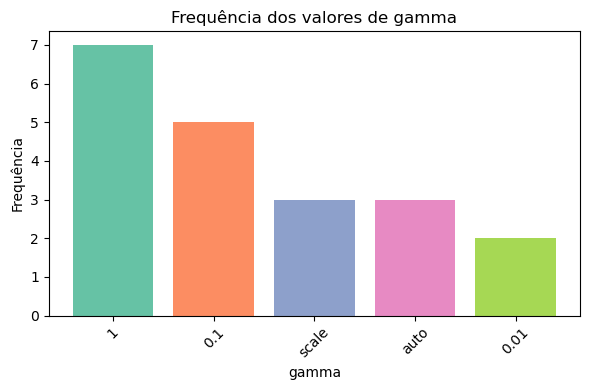

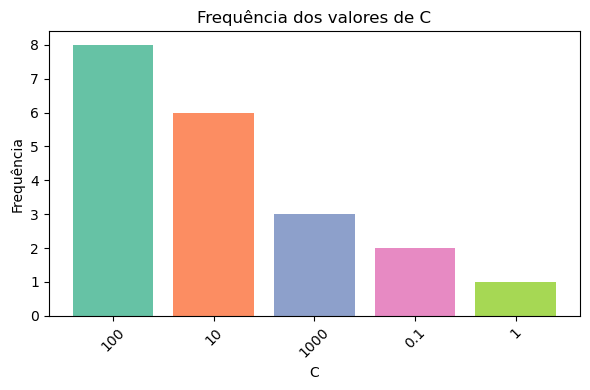

Time taken for hyperparameter search: 292.08 seconds


In [ ]:
best_params_stacking = search_hyperparameters(
    StackingClassifier(estimators=base_estimators, final_estimator=LogisticRegression(), n_jobs=-1),
    params_stacking,
    'stacking',
    metric='accuracy'
)

In [ ]:
best_params_stacking

{'n_estimators': 250,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'log2',
 'max_depth': None,
 'class_weight': 'balanced_subsample'}

Cross-Validation for Params:   0%|          | 0/20 [00:00<?, ?it/s]

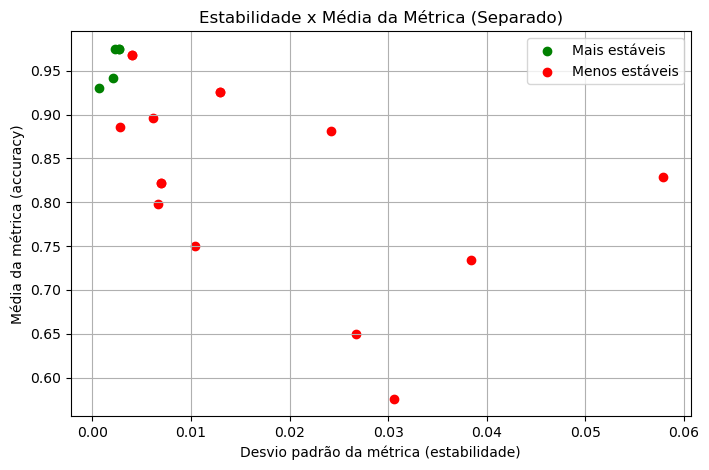

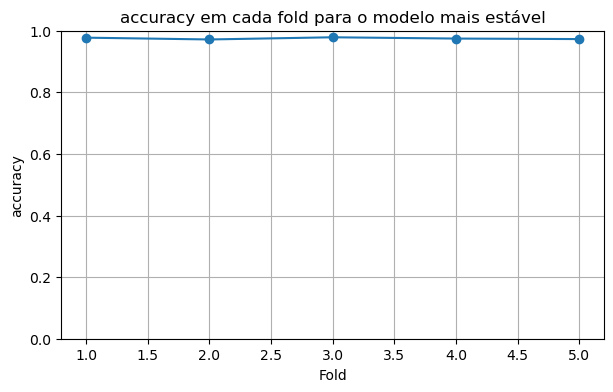

In [ ]:
best_params_stacking = cross_val_stability_analysis(
    lambda: StackingClassifier(estimators=base_estimators, final_estimator=LogisticRegression(), n_jobs=-1),
    best_params_stacking,
    metric='accuracy'
)


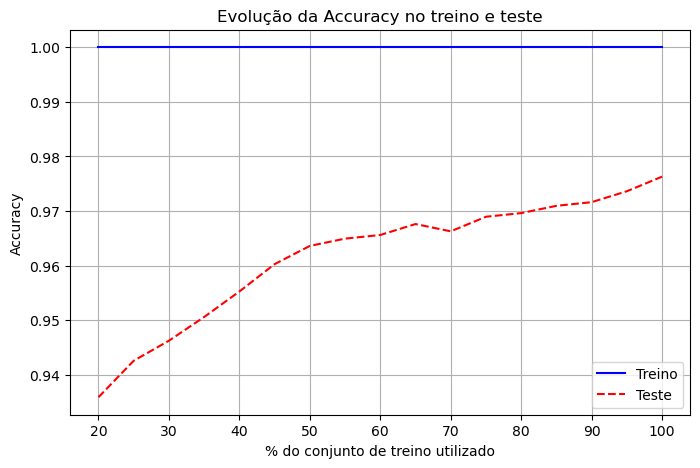

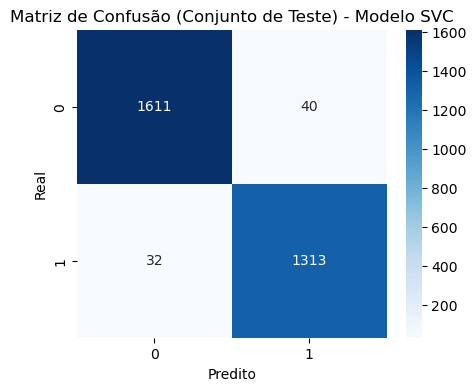

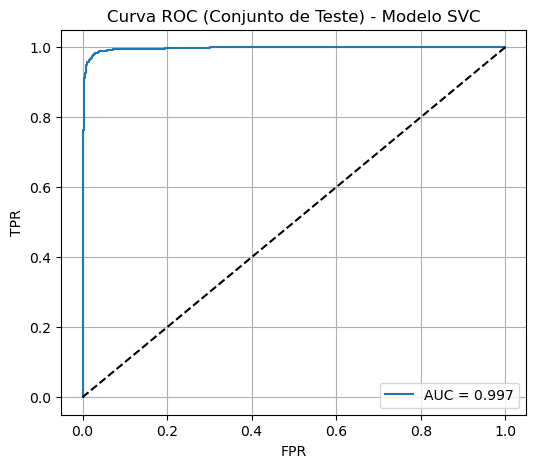

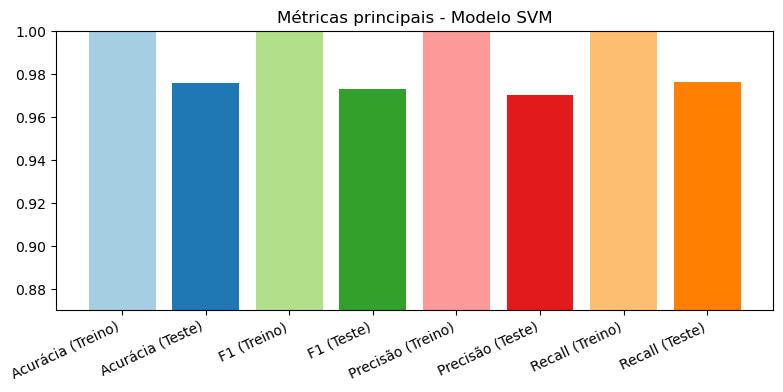

In [ ]:
results_stacking = evaluate_and_plot(
    best_params_stacking,
    lambda: StackingClassifier(estimators=base_estimators, final_estimator=LogisticRegression(), n_jobs=-1),
    metric='accuracy',
    model_name='Stacking'
)


### 6.4 XGBoost

Searching Hyperparameters:   0%|          | 0/20 [00:00<?, ?it/s]

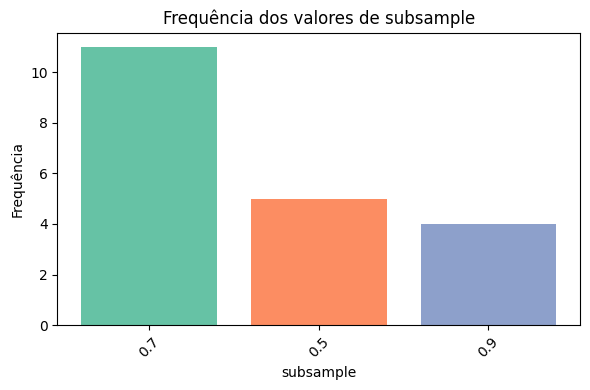

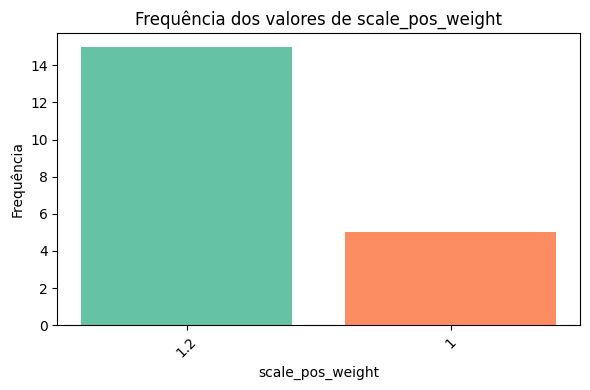

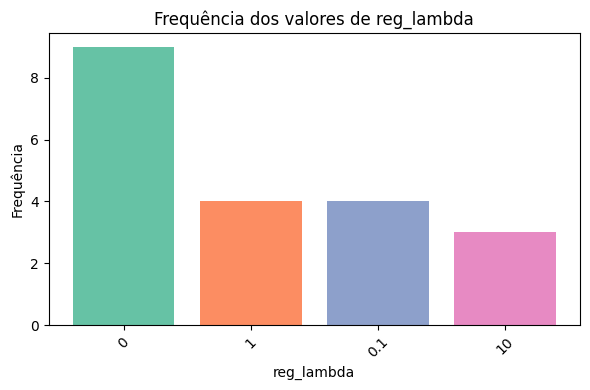

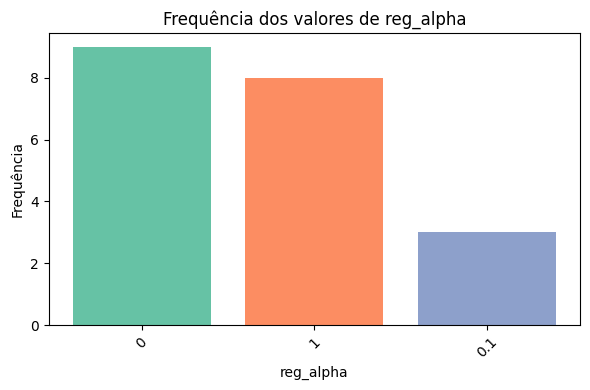

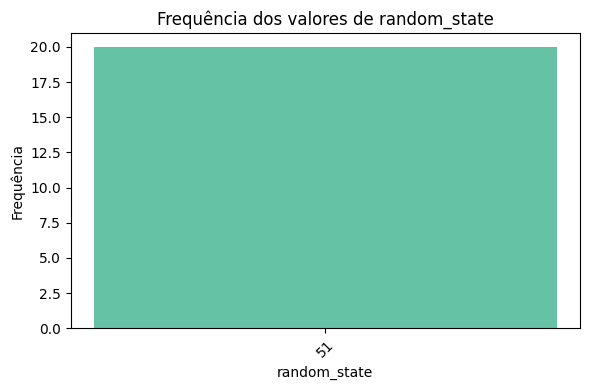

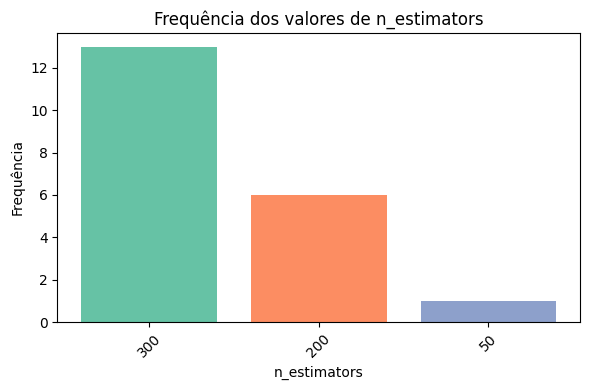

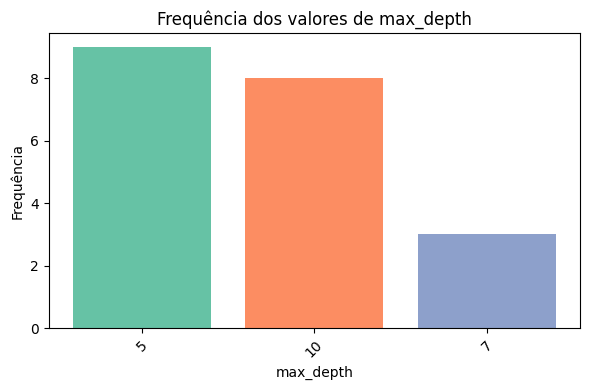

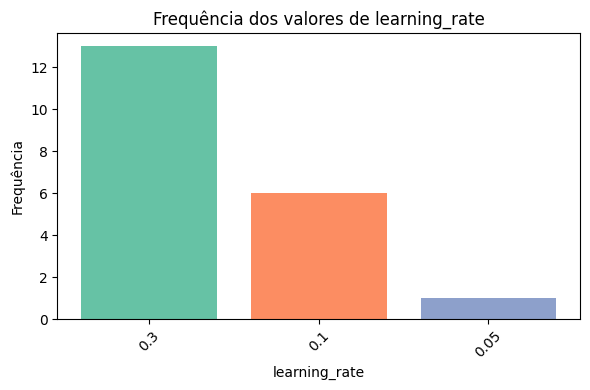

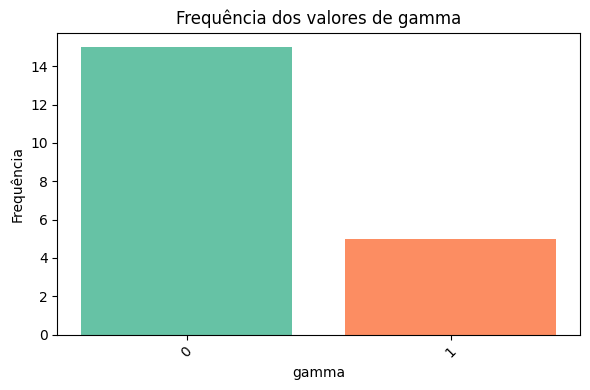

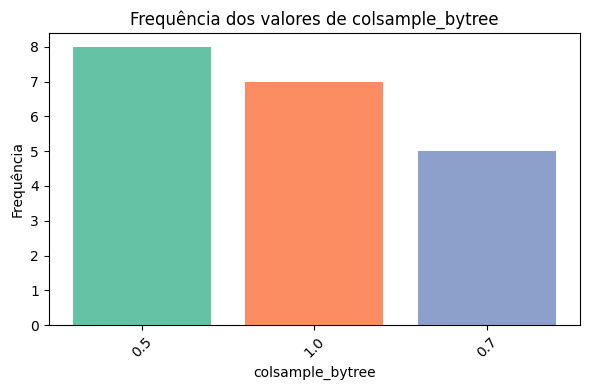

Time taken for hyperparameter search: 621.50 seconds


In [30]:
best_params_xgboost = search_hyperparameters(
    xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    params_xgboost,
    'xgboost',
    metric='accuracy'
)

In [44]:
best_params_xgboost

[{'subsample': 0.9,
  'scale_pos_weight': 1.2,
  'reg_lambda': 1,
  'reg_alpha': 0.1,
  'random_state': 51,
  'n_estimators': 300,
  'max_depth': 10,
  'learning_rate': 0.3,
  'gamma': 1,
  'colsample_bytree': 1.0},
 {'subsample': 0.9,
  'scale_pos_weight': 1.2,
  'reg_lambda': 0,
  'reg_alpha': 0,
  'random_state': 51,
  'n_estimators': 200,
  'max_depth': 7,
  'learning_rate': 0.1,
  'gamma': 0,
  'colsample_bytree': 0.7},
 {'subsample': 0.9,
  'scale_pos_weight': 1,
  'reg_lambda': 0,
  'reg_alpha': 0.1,
  'random_state': 51,
  'n_estimators': 300,
  'max_depth': 5,
  'learning_rate': 0.3,
  'gamma': 1,
  'colsample_bytree': 0.5},
 {'subsample': 0.5,
  'scale_pos_weight': 1,
  'reg_lambda': 0.1,
  'reg_alpha': 1,
  'random_state': 51,
  'n_estimators': 300,
  'max_depth': 10,
  'learning_rate': 0.3,
  'gamma': 1,
  'colsample_bytree': 0.7},
 {'subsample': 0.7,
  'scale_pos_weight': 1.2,
  'reg_lambda': 10,
  'reg_alpha': 0,
  'random_state': 51,
  'n_estimators': 300,
  'max_depth':

Cross-Validation for Params:   0%|          | 0/20 [00:00<?, ?it/s]

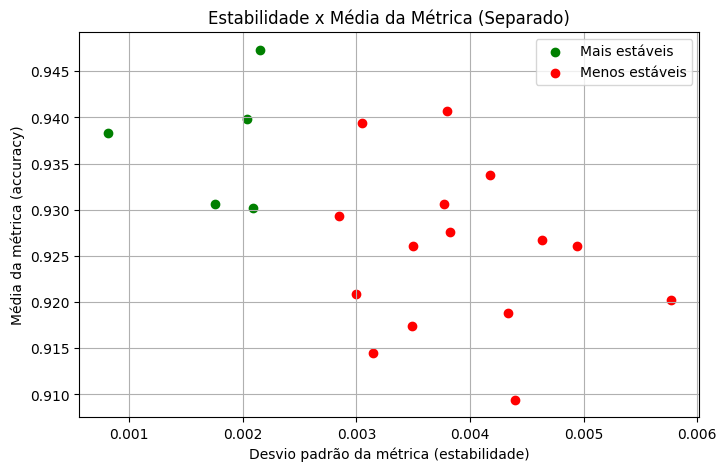

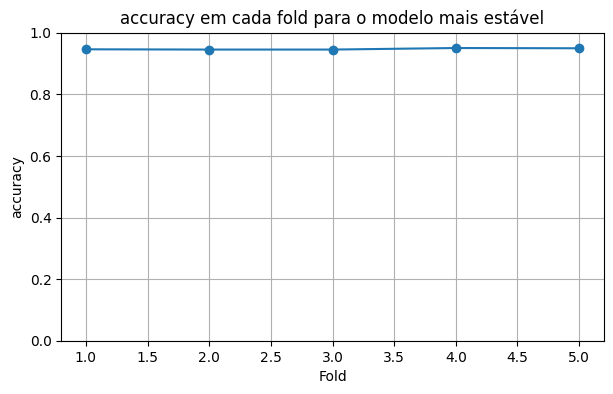

In [45]:
# Verificar se best_params_xgboost é uma lista ou um único dicionário
if isinstance(best_params_xgboost, dict):
    # Se for um dicionário único, transformar em lista
    param_list_xgboost = [best_params_xgboost]
else:
    # Se for uma lista, usar como está
    param_list_xgboost = best_params_xgboost

best_param_xgboost = cross_val_stability_analysis(
    lambda **params: xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', **params),
    param_list_xgboost, 
    metric='accuracy'
)

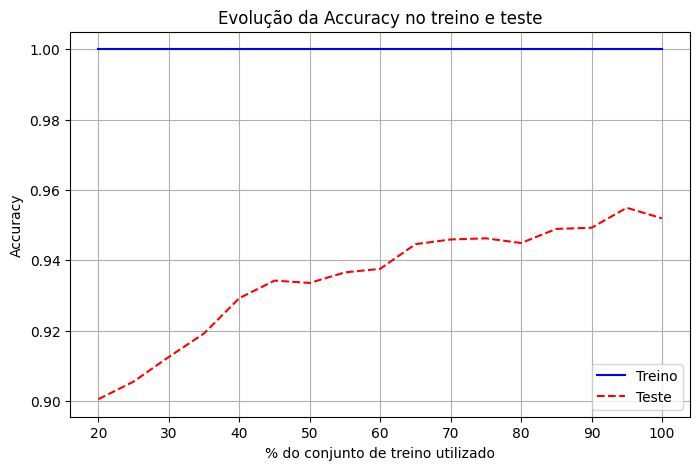

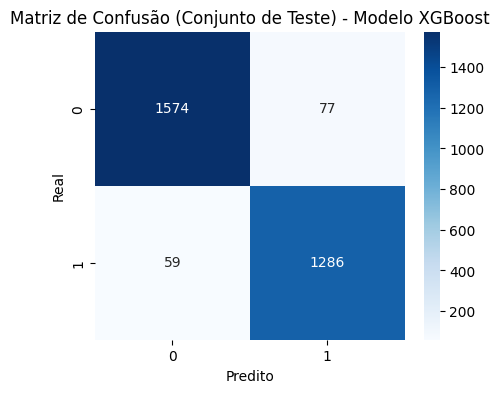

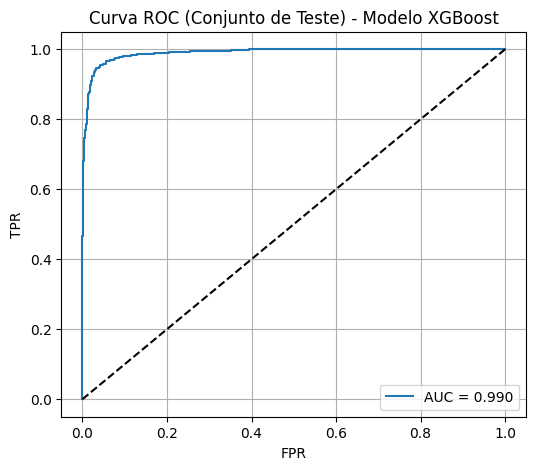

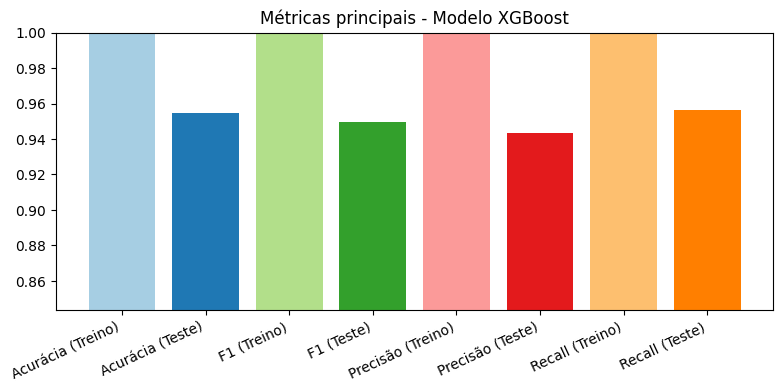

In [50]:
# Avaliação final do XGBoost com o melhor conjunto de parâmetros
results_xgboost = evaluate_and_plot_xgboost(
    best_param_xgboost, 
    lambda **params: xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', **params), 
    metric='accuracy', 
    model_name='XGBoost'
)

### 6.5 LightGBM

Searching Hyperparameters:   0%|          | 0/8 [00:00<?, ?it/s]

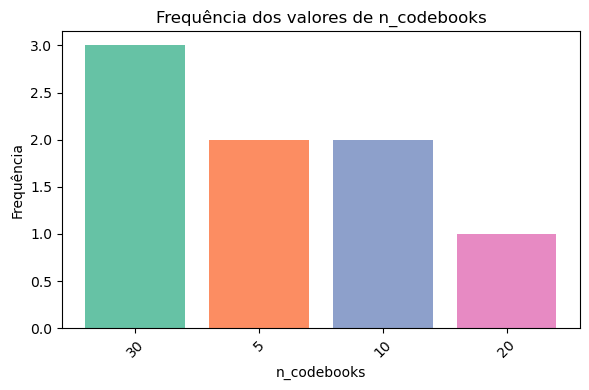

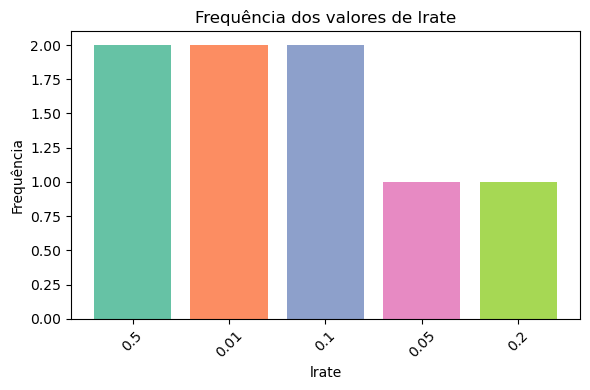

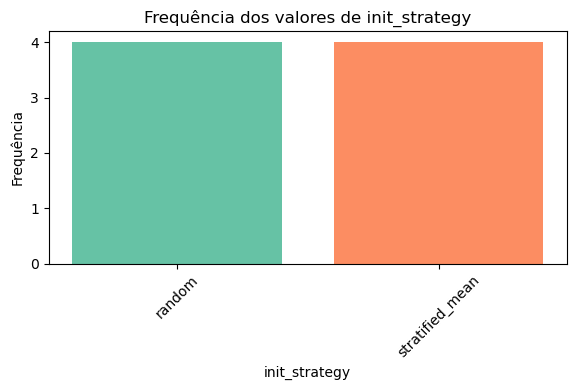

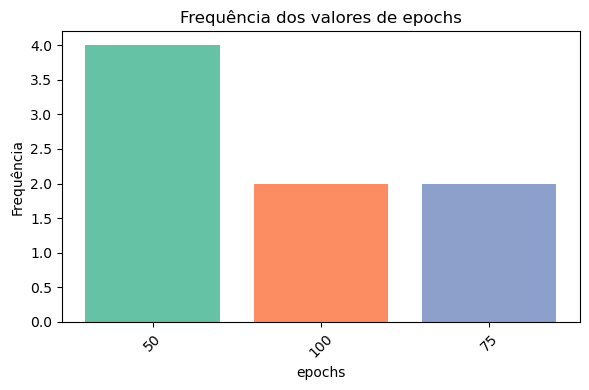

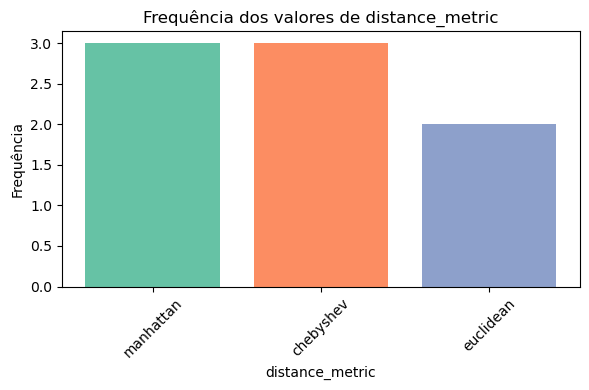

Time taken for hyperparameter search: 5004.63 seconds


In [ ]:
best_params_lightgbm = search_hyperparameters(
    lgb.LGBMClassifier(),
    params_lightgbm,
    'lightgbm',
    metric='accuracy'
)


Cross-Validation for Params:   0%|          | 0/8 [00:00<?, ?it/s]

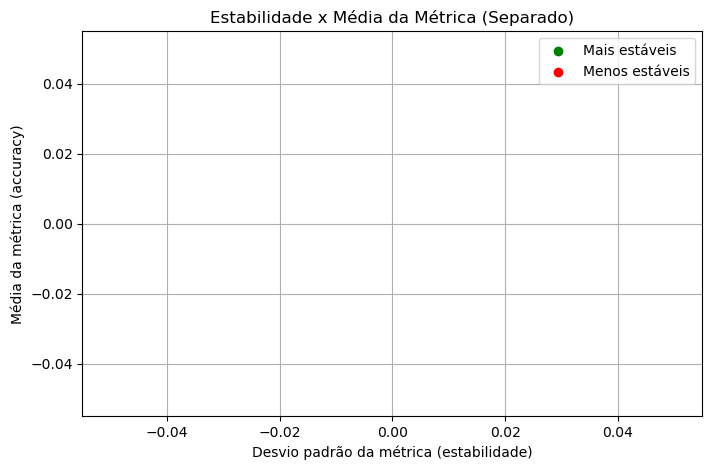

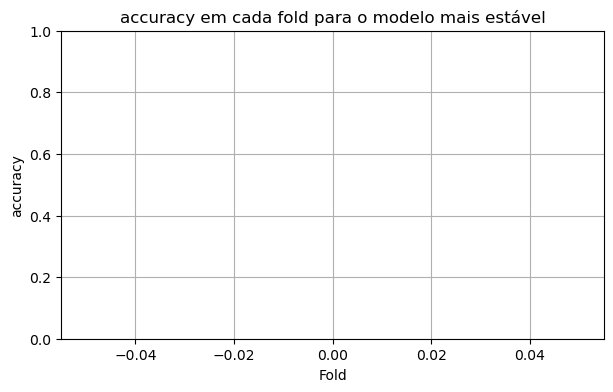

In [ ]:
best_params_lightgbm = cross_val_stability_analysis(
    lgb.LGBMClassifier,
    best_params_lightgbm,
    metric='accuracy'
)


In [ ]:
results_lightgbm = evaluate_and_plot(
    best_params_lightgbm,
    lgb.LGBMClassifier,
    metric='accuracy',
    model_name='LightGBM'
)


ValueError: operands could not be broadcast together with shapes (14,) (13,) 

In [ ]:
import pandas as pd

results_mlp['model'] = 'MLP'
results_bagging_mlp['model'] = 'Comitê MLP'
results_stacking['model'] = 'Stacking'
results_xgboost['model'] = 'XGBoost'
results_lightgbm['model'] = 'LightGBM'

df = pd.DataFrame([
    results_mlp,
    results_bagging_mlp,
    results_stacking,
    results_xgboost,
    results_lightgbm
])

df


,accuracy_train,accuracy_test,f1_train,f1_test,precision_train,precision_test,recall_train,recall_test,auc,model
0,1.0,0.842123,1.0,0.825009,1.0,0.821060,1.0,0.828996,0.840906,Decision Tree
1,1.0,0.965287,1.0,0.961595,1.0,0.955246,1.0,0.968030,0.965541,KNN
2,1.0,0.975968,1.0,0.973314,1.0,0.970436,1.0,0.976208,0.996729,SVM
3,1.0,0.931242,1.0,0.922147,1.0,0.937740,1.0,0.907063,0.983508,Random Forest
